In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

$$J_{surr}= {1 \over N} \sum\limits_{i=0}^N \frac{\pi_{\theta}(s_i, a_i)}{\pi_{\theta_{old}}(s_i, a_i)}A_{\theta_{old}(s_i, a_i)}$$

$$J'_{surr}= {1 \over N} \sum\limits_{i=0}^N \frac{\pi_{\theta}(s_i, a_i)}{\pi_{\theta_{old}}(s_i, a_i)}G_{\theta_{old}(s_i, a_i)}$$

In [2]:
device = torch.device(['cpu', 'cuda:0'][torch.cuda.is_available()])

In [67]:
GAMMA = 0
LEARNING_RATES = [7e-4, 3e-4]
BETA = 0.01
ACTOR_ARH = [128]
CRTIC_ARH = [128]
EPS_CLIP = 0.2

In [68]:
import math

sig_dbg = []
mu_dbg = []
actor_losses = []
critic_losses = []

sigma_const = 0.3

class ActorPPO(nn.Module):
    def __init__(self, inner_size=[64,64]):
        super(ActorPPO,self).__init__()
        
        self.actoin_space = env.action_space.shape[0]
        self.action_min = env.action_space.low
        self.action_max = env.action_space.high
        self.observation_space = env.observation_space.shape[0]
        
        self.sigma_const = 0.3
        
        seq = []
        for i in range(len(inner_size)):
            if i == 0:
                seq += [nn.Linear(self.observation_space, inner_size[i])]
                seq += [nn.Tanh()]
            else:
                seq += [nn.Linear(inner_size[i-1], inner_size[i])]
            
            if i < len(inner_size)-1:
                seq += [nn.Tanh()]
        
        self.main = nn.Sequential(
            *seq
        )

        
        self.mu_out = nn.Linear( inner_size[-1], self.actoin_space )
        self.sig_out = nn.Linear( inner_size[-1], self.actoin_space )
        
        self.init_w(self.mu_out)
        self.init_w(self.sig_out)
        
        self.main.apply(self.init_w)
    
    def init_w(self, a):
        if isinstance(a, nn.Linear):
            torch.nn.init.xavier_uniform(a.weight)
        
    def forward(self, inp):
        x = self.main(inp)
        mu = F.tanh(self.mu_out(x))
        sig = F.softplus(self.sig_out(x)) + 1e-10
        
        #sig = torch.full_like( mu, self.sigma_const )
        
        return mu, sig

class Critic(nn.Module):
    def __init__(self, inner_size):
        super(Critic,self).__init__()
        
        self.actoin_space = env.action_space.shape[0]
        self.observation_space = env.observation_space.shape[0]
        
        seq = []
        for i in range(len(inner_size)):
            if i == 0:
                seq += [nn.Linear(self.observation_space, inner_size[i])]
                seq += [nn.Tanh()]
            if i == len(inner_size)-1:
                seq += [nn.Linear(inner_size[i], 1)]
                #seq += [nn.Linear(inner_size[i], self.actoin_space)]
            else:
                seq += [nn.Linear(inner_size[i-1], inner_size[i])]
            
            if i < len(inner_size)-1:
                seq += [nn.Tanh()]
        
        self.main = nn.Sequential(
            *seq
        )
        
        self.main.apply(self.init_w)
    
    def init_w(self, a):
        if isinstance(a, nn.Linear):
            torch.nn.init.xavier_uniform(a.weight)
    
    def forward(self, inp):
        return self.main(inp)

class ReplayBufferPPO():
    def __init__(self, size = 100):
        
        self.size = size
        self.actoin_space = env.action_space.shape[0]
        self.observation_space = env.observation_space.shape[0]
        
        self.states = []
        self.probs = []
        self.rewards = []
        
        self.eps = torch.tensor(1e-8).to(device)
        
        self.begin_episode()
        
    def begin_episode(self):
        self.actions = []
        self.states = []
        self.probs = []
        self.rewards = []
        self.dones = []
        self.entropy = []
        
    def add_obs(self, a, p, s, r, d, e):
        
        self.actions += [a]
        self.states += [s]
        self.probs += [p]
        self.rewards += [r]
        self.dones += [not d]
        self.entropy += [e]
        
    def sample_actor(self):
        
        probs = torch.cat(self.probs).to(device)
        entrs = torch.cat(self.entropy).to(device)
        
        return probs, entrs
    
    def sample_critic(self):
        
#         states = np.concatenate(self.states).reshape(-1, self.observation_space)
        states = self.states
        states = torch.Tensor(states).to(device)
        actions = torch.tensor(self.actions).to(device)
        rewards = torch.tensor(self.rewards).to(device)
        next_states = torch.roll(states,-1, dims=0)
        #next_action_mask = torch.ones(len(self.rewards)).to(device)
        next_action_mask = torch.tensor(self.dones).float().to(device)
        
        
        returns = [\
            np.dot( GAMMA**np.arange(1,len(self.rewards)-i+1), self.rewards[i:] )\
            for i in range(len(self.rewards))
        ]
        returns = torch.tensor(returns).to(device)
        
        return states, next_states, actions, rewards,\
        next_action_mask, returns

class AgentPPO():
    def __init__(self, rb):
        
        self.policy_model = ActorPPO(ACTOR_ARH).to(device)
        self.value_model = Critic(CRTIC_ARH).to(device)
        
        self.actoin_space = env.action_space.shape[0]
        self.action_min = torch.tensor(env.action_space.low).to(device)
        self.action_max = torch.tensor(env.action_space.high).to(device)
        
        self.replay = rb
        
        self.policy_opt = torch.optim.Adam(
            self.policy_model.parameters(), lr=LEARNING_RATES[0],
        )
        
        self.value_opt = torch.optim.Adam(
            self.value_model.parameters(), lr=LEARNING_RATES[1]
        )
    
    def train_critic(self, states, next_states, actions, 
                     rewards, next_state_masks, returns_r):
        
        nextq = self.value_model(next_states).view(-1) * next_state_masks
        target = (rewards + GAMMA * nextq).detach().data
        adv = target - self.value_model(states).view(-1)
        loss = (adv**2.0).mean()
        
        self.value_opt.zero_grad()
        loss.backward()
        self.value_opt.step()
        
        return loss.item(), adv
        
    def train_actor(self, old_log_probs, old_states, 
                    old_entropy, old_actions, adv):
        
        log_probs, entropy = self.evaluate( old_states, old_actions )
        ratios = torch.exp(log_probs - old_log_probs.detach())
        surr1 = ratios * adv.view(-1,1).detach()
        surr2 = torch.clamp(ratios, 1-EPS_CLIP, 1+EPS_CLIP) * adv.view(-1,1).detach()
        e_reg = BETA*entropy.mean()
        lclip = -torch.min(surr1, surr2).mean()
        loss = lclip - e_reg
        
        self.policy_opt.zero_grad()
        loss.backward()
        self.policy_opt.step()
        
        return loss.item(), e_reg.item()
    
    def train_iter(self):
        
        log_probs, entropy = self.replay.sample_actor()
        states, next_states, actions,\
        rewards, next_state_masks, returns_r = self.replay.sample_critic()
        
        critic_loss, returns_ac = self.train_critic(
            states, 
            next_states, 
            actions,
            rewards, 
            next_state_masks, 
            returns_r
        )
        
        actor_loss, entr_loss = self.train_actor(
            log_probs,
            states,
            entropy,
            actions,
            returns_ac #advantages
        )
        
        return actor_loss, critic_loss, entr_loss
    
    def evaluate(self, states, actions):
        mu, sig = self.policy_model(states)
        #print('musi', mu.shape, sig.shape)
        act_distr = torch.distributions.Normal(mu, sig)
        log_probs = act_distr.log_prob(actions)
        entropy = act_distr.entropy()
        
        return log_probs, entropy
        
    def select(self, state, explore=True):
        
        t_state = torch.tensor(state).float().unsqueeze(0).to(device)
        mu, sig = self.policy_model(t_state)
        act_distr = torch.distributions.Normal(mu.view(-1), sig.view(-1))
        
        if not explore:
            act = mu
            log_probs = None
            entropy = None
            actc = act.detach().cpu().numpy().squeeze()
        else:
            act = act_distr.sample()
            log_probs = act_distr.log_prob(act).view(1,-1)
            actc = act.detach().cpu().numpy().squeeze()
            entropy = act_distr.entropy()
            
            global sig_dbg, mu_dbg
            sig_dbg += [ sig.detach().cpu().numpy().mean() ]
            mu_dbg += [ mu.detach().cpu().numpy().mean() ]
        
        return actc, log_probs, entropy

In [69]:
def ma(X, n):
    return np.convolve(X, np.ones((n,)) / n, mode='valid')

def ms(X, n):
    return np.convolve(X, np.ones((n,)), mode='valid')

def softmax(arr):
    return np.exp(arr) / np.sum(np.exp(arr))

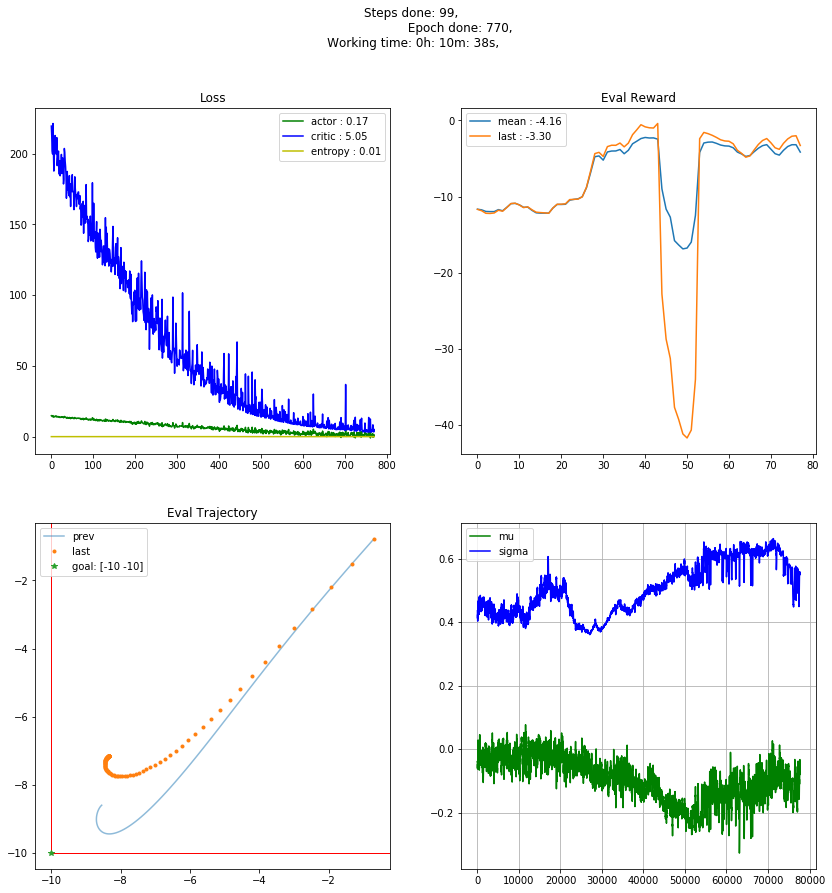

0.6678050756454468 3.4765987396240234 0.011318339966237545


In [ ]:
# import pybulletgym
from point_mass_observed import ObservedPointEnv
from IPython import display
import datetime

# test_env = Normalize(env)
# eval_env = Normalize(env, ret=False)
start = datetime.datetime.now()

loss_stats = {'policy_loss':[],
                 'loss':[],
                 'value_loss':[]}

eval_rewards = {'mean': [],
                'last': []}

eval_observations = {'point' : []}

env = ObservedPointEnv(2)
env.unwrapped.seed(0)

torch.manual_seed(42)

buffer = ReplayBufferPPO()
agent = AgentPPO(buffer)

total_rewards = []
total_lengths = []

actor_losses = []
critic_losses = []
entr_losses = []

frames = []

solve_threshold = 0
max_episode = 100000000

cnt = 0

for e in tqdm(range(1000)):
    
    buffer.begin_episode()
    
    s = env.reset()
    a, probs, entr = agent.select(s)
    
    total_reward = 0
    total_length= 0
    
    if e % 10 == 0:
        observation = env.reset()
        eval_observations = {'point' : []}
        sum_reward = 0

        for step in range(int(1e12)):
            action, _, _ = agent.select(observation, explore=False)
            
            observation, reward, done, info = env.step(action)
            eval_observations['point'].append(observation[:2])

            sum_reward += reward
            if done:
                break
        eval_rewards['mean'] += [sum_reward / step]
        eval_rewards['last'] += [reward]
    
    for t in range(100000):
        s_, r, done, info = env.step(a)
        
        total_reward += r
        total_length += 1

        buffer.add_obs( a, probs, s, r, done, entr )
        
        a, probs, entr = agent.select(s_)

        s = s_
        
        if t % 100 == 1:
            a_loss, c_loss, e_loss = agent.train_iter()
        
        if t == max_episode-1: done = True
        
        if done:
            
            print(a_loss, c_loss, e_loss)

            actor_losses += [a_loss]
            critic_losses += [c_loss]
            entr_losses += [e_loss]
            cnt += 1
        
        if done:
            

            
            total_rewards += [total_reward]
            total_lengths += [total_length]
            
            
#             clear_output(wait=True)
            
#             f = plt.figure(figsize=(20,5))
#             ax = f.add_subplot(131)
#             ax2 = f.add_subplot(132)
#             ax3 = f.add_subplot(133)
            
#             ax.grid(True)
#             ax.set_title('Total rewards')
#             ax.plot(total_rewards)
#             #plt.show()
            
#             if True:
#                 ax2.grid(True)
#                 ax2.set_title('Outputs')
#                 ax2.plot( ma(mu_dbg, 100), label='mu', color='g' )
#                 ax2.plot( ma(sig_dbg, 100), label='sigma', color='b' )
#                 ax2.legend()
#                 #plt.show()
            
#             ax3.grid(True)
#             ax3.set_title('Losses')
#             ax3.plot( actor_losses, label='actor', color='g' )
#             ax3.plot( critic_losses, label='critic', color='b' )
#             ax3.plot( entr_losses, label='entropy', color='y' )
#             ax3.legend()
#             plt.show()
            
            display.clear_output(wait=True)            
    #                                                                                                      action_distr))            
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

            working_time = datetime.datetime.now() - start

            fig.suptitle(f'Steps done: {t}, \n \
                        Epoch done: {e}, \n \
                      Working time: {working_time.seconds//3600}h: {(working_time.seconds//60)%60}m: {working_time.seconds%60}s, \
                      ')

            ax[0,0].plot( actor_losses, label='actor'+ ' : {:.2f}'.format(actor_losses[-1]), color='g' )
            ax[0,0].plot( critic_losses, label='critic'+ ' : {:.2f}'.format(critic_losses[-1]), color='b' )
            ax[0,0].plot( entr_losses, label='entropy'+ ' : {:.2f}'.format(entr_losses[-1]), color='y' )
            ax[0,0].legend()
            ax[0,0].set_title('Loss')

            for k in eval_rewards.keys():
                ax[0,1].plot(eval_rewards[k], label = k + ' : {:.2f}'.format(eval_rewards[k][-1]))
            ax[0,1].legend()
            ax[0,1].set_title('Eval Reward')

            if t != 1:
                ax[1,0].plot(xs, ys, '-', alpha=0.5, label='prev')
            xs, ys = zip(*eval_observations['point'])        
            ax[1,0].plot(xs, ys, '.', label='last')
            
            ax[1,0].plot(env._goal[0], env._goal[1], '*', label=f'goal: {env._goal}')
            rect = patches.Rectangle((-10,-10), 20, 20, linewidth=1, edgecolor='r',facecolor='none')
            ax[1,0].add_patch(rect)
            ax[1,0].legend()
            ax[1,0].set_title('Eval Trajectory')  
            
            ax[1,1].plot( ma(mu_dbg, 100), label='mu', color='g' )
            ax[1,1].plot( ma(sig_dbg, 100), label='sigma', color='b' )
            ax[1,1].legend()
            ax[1,1].grid()

            plt.show()
            
            if e % 10 == 3:
                print('mu', np.mean(mu_dbg[-10:]), 'sig', np.mean(sig_dbg[-10:]))
            
            break

In [49]:
%debug

> <ipython-input-44-200da0de919e>(126)sample_actor()
    124     def sample_actor(self):
    125 
--> 126         probs = torch.cat(self.probs).to(device)
    127         entrs = torch.cat(self.entropy).to(device)
    128 

ipdb> self.probs
[None, tensor([[-0.5395, -0.5772]], device='cuda:0', grad_fn=<ViewBackward>)]
ipdb> й
*** NameError: name 'й' is not defined
ipdb> q


In [7]:
# states = np.concatenate(buffer.states).reshape(-1, buffer.observation_space)
states = torch.tensor(buffer.states).to(device)
actions = torch.tensor(buffer.actions).to(device)
rewards = torch.tensor(buffer.rewards).to(device)
next_states = torch.roll(states,-1, dims=0)

In [40]:
# # plt.plot(xs, ys, '-', alpha=0.5, label='prev')
# import matplotlib.patches as patches

# eval_rewards = {'mean': [],
#                 'last': []}

# observation = env.reset()
# eval_observations = {'point' : []}
# total_reward = 0

# for step in range(int(1e12)):
#     action, probs, entr = agent.select(observation, explore=False)

#     observation, reward, done, info = env.step(action)
#     eval_observations['point'].append(observation[:2])

#     total_reward += reward
#     if done:
#         break
        
# eval_rewards['mean'] += [total_reward / step]
# eval_rewards['last'] += [reward]

# xs, ys = zip(*eval_observations['point'])        
# plt.plot(xs, ys, '.', label='last')
# #         ax[1,0].plot(prev_xs, prev_ys, '-', alpha=0.5)
# plt.plot(env._goal[0], env._goal[1], '*', label=f'goal: {env._goal}')
# rect = patches.Rectangle((-10,-10), 20, 20, linewidth=1, edgecolor='r',facecolor='none')
# # plt.add_patch(rect)
# #         ax[1,0].set_aspect('equal', adjustable='box')
# plt.legend()
# plt.grid()
# plt.title('Eval Trajectory')        

# plt.show()

In [8]:
obs = torch.Tensor(env.reset()).to(device)

agent.value_model(obs)

tensor([0.1959], device='cuda:0', grad_fn=<AddBackward0>)

In [9]:
obs = torch.Tensor(buffer.states).to(device)

agent.value_model(obs)

tensor([[0.1959],
        [0.1674]], device='cuda:0', grad_fn=<AddmmBackward>)

In [15]:
states

tensor([[0.0000, 0.0000, 0.0000, 1.0000],
        [0.3459, 1.1015, 0.0000, 1.0000]], device='cuda:0',
       dtype=torch.float64)

In [16]:
obs

tensor([[0.0000, 0.0000, 0.0000, 1.0000],
        [0.3459, 1.1015, 0.0000, 1.0000]], device='cuda:0')

In [14]:
# obs = torch.Tensor(states).to(device)

agent.value_model(states.double())

RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #4 'mat1'

In [46]:
buffer.states

[array([0., 0., 0., 1.]),
 array([0.34585416, 1.10150099, 0.        , 1.        ])]

In [45]:
states

False

In [24]:
np.concatenate(buffer.states).reshape(-1, buffer.observation_space)

array([[0.        , 0.        , 0.        , 1.        ],
       [0.34585416, 1.10150099, 0.        , 1.        ]])

In [53]:
# states = np.concatenate(buffer.states).reshape(-1, buffer.observation_space)
states = torch.tensor(buffer.states).to(device)
actions = torch.tensor(buffer.actions).to(device)
rewards = torch.tensor(buffer.rewards).to(device)
next_states = torch.roll(states,-1, dims=0)

In [54]:
states, next_states

(tensor([[0.0000, 0.0000, 0.0000, 1.0000],
         [0.3459, 1.1015, 0.0000, 1.0000]], device='cuda:0',
        dtype=torch.float64), tensor([[0.3459, 1.1015, 0.0000, 1.0000],
         [0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0',
        dtype=torch.float64))

In [31]:
torch.roll(states,-1, dims=0)

tensor([[0.3459, 1.1015, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0',
       dtype=torch.float64)